In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
import glob


def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-18 16:41:26.568353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 16:41:26.777753: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 16:41:26.829534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-18 16:41:29.792349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #0


## 1. Preparing Dataset PBMC

In [2]:


def filter_cv_vs_mean(S: np.ndarray, N: int, svr_gamma: float=None, plot: bool=True, min_expr_cells: int=2,
                      max_expr_avg: float=20, min_expr_avg: float=0) -> np.ndarray:
    muS = S.mean(1)
    detected_bool = ((S > 0).sum(1) > min_expr_cells) & (muS < max_expr_avg) & (muS > min_expr_avg)
    
    Sf = S[detected_bool, :]
    mu = Sf.mean(1)
    sigma = Sf.std(1, ddof=1)

    cv = sigma / mu
    log_m = np.log2(mu)
    log_cv = np.log2(cv)
    
    if svr_gamma is None:
        svr_gamma = 150. / len(mu)
    
    svr = SVR(gamma=svr_gamma)
    svr.fit(log_m[:, None], log_cv)
    fitted_fun = svr.predict
    ff = fitted_fun(log_m[:, None])
    score = log_cv - ff

    xnew = np.linspace(np.min(log_m), np.max(log_m))
    ynew = svr.predict(xnew[:, None])

    nth_score = np.sort(score)[::-1][N]
    
    if plot:
        plt.scatter(log_m[score > nth_score], log_cv[score > nth_score], s=3, alpha=0.4, c="tab:red")
        plt.scatter(log_m[score <= nth_score], log_cv[score <= nth_score], s=3, alpha=0.4, c="tab:blue")
        mu_linspace = np.linspace(np.min(log_m), np.max(log_m))
        plt.plot(mu_linspace, fitted_fun(mu_linspace[:, None]), c="k")
        plt.xlabel("log2 mean S")
        plt.ylabel("log2 CV S")
    
    cv_mean_score = np.zeros(detected_bool.shape)
    cv_mean_score[~detected_bool] = np.min(score) - 1e-16
    cv_mean_score[detected_bool] = score
    cv_mean_selected = cv_mean_score >= nth_score
    return cv_mean_selected



In [3]:
data_dir = "./"

In [4]:
# Remove file prefixes if any
prefix = "pbmc_granulocyte_sorted_10k_"
for file in os.listdir(data_dir):
    if file.startswith(prefix):
        new_filename = file[len(prefix):]
        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [5]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from ./filtered_feature_bc_matrix.h5


/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


Added peak annotation from ./atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: ./atac_fragments.tsv.gz


[W::hts_idx_load3] The index file is older than the data file: ./atac_fragments.tsv.gz.tbi


MuData object with n_obs × n_vars = 11909 × 144978
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	11909 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	11909 x 108377
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'atac', 'files'

## RNA

In [6]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

#### Preprocessing

#### QC

In [7]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

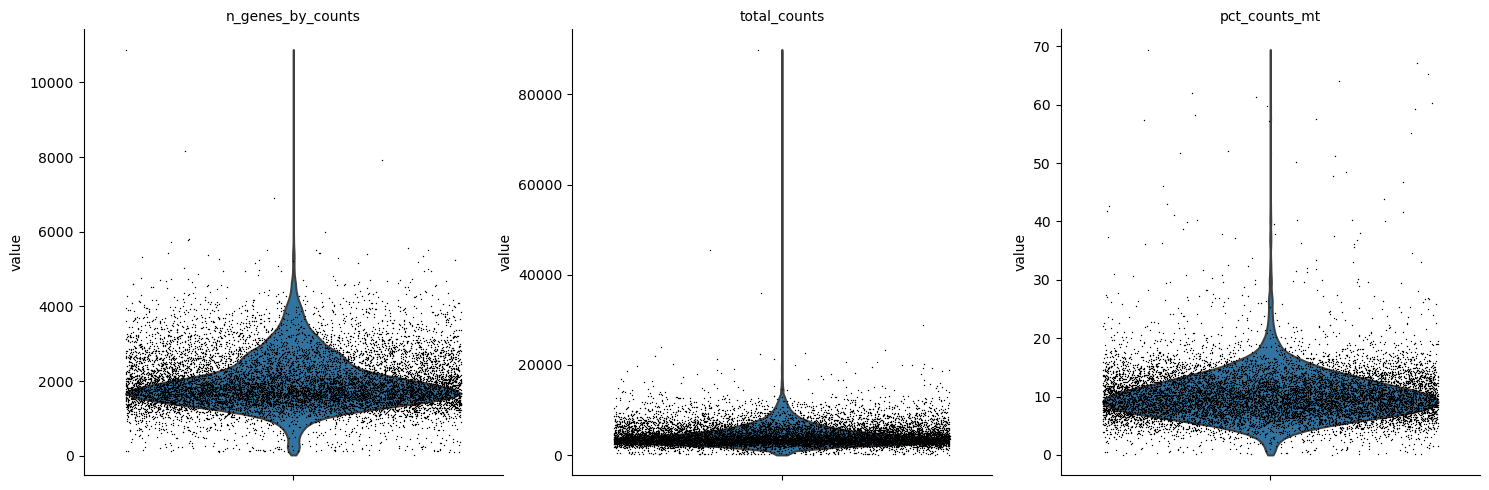

In [8]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [9]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

In [10]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

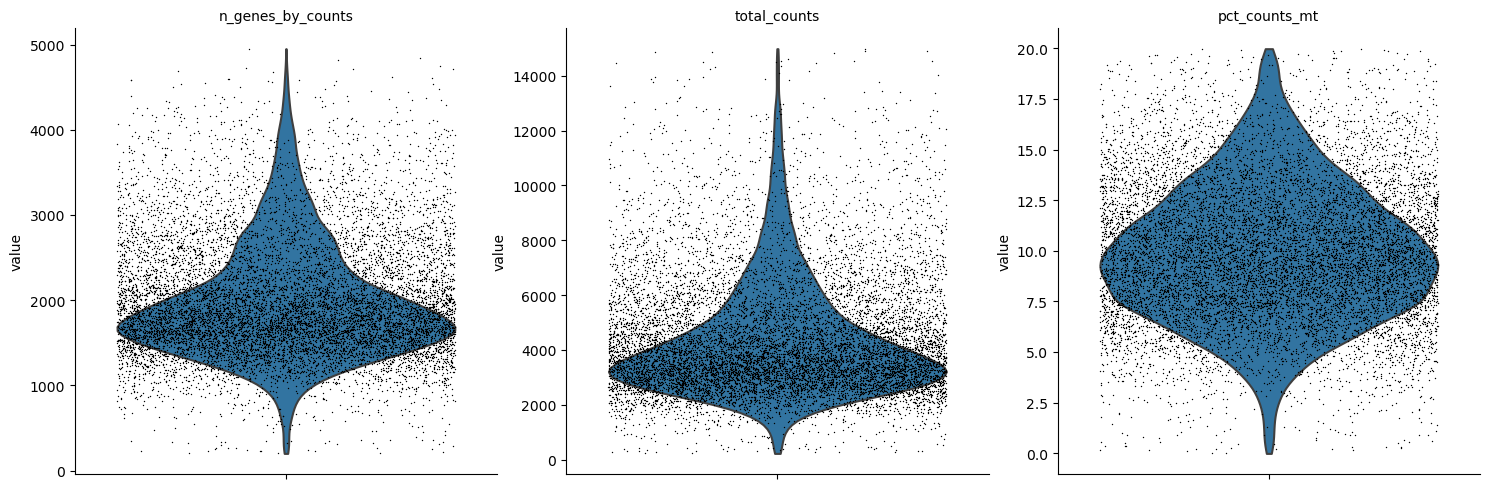

In [11]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

#### Normalisation

In [12]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [13]:
sc.pp.log1p(rna)

#### Feature selection

In [14]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

In [15]:
rna

AnnData object with n_obs × n_vars = 11565 × 26349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

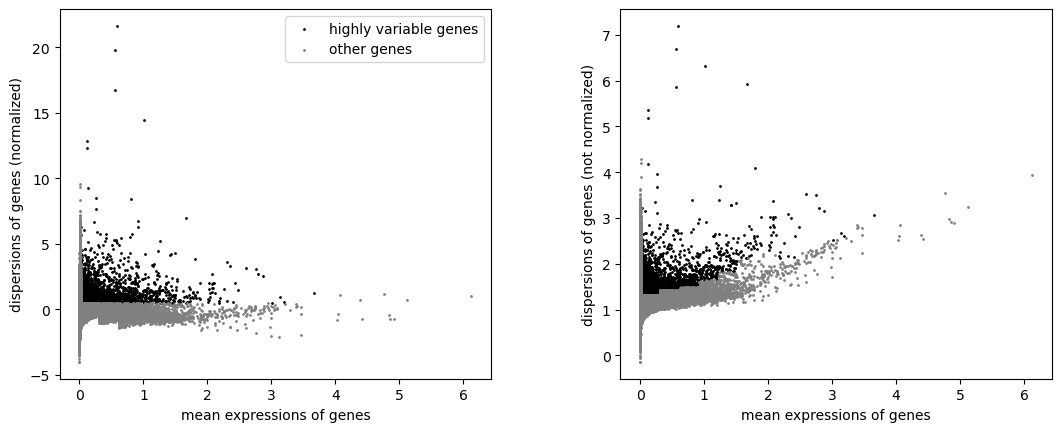

In [16]:
sc.pl.highly_variable_genes(rna)

In [17]:
np.sum(rna.var.highly_variable)

3026

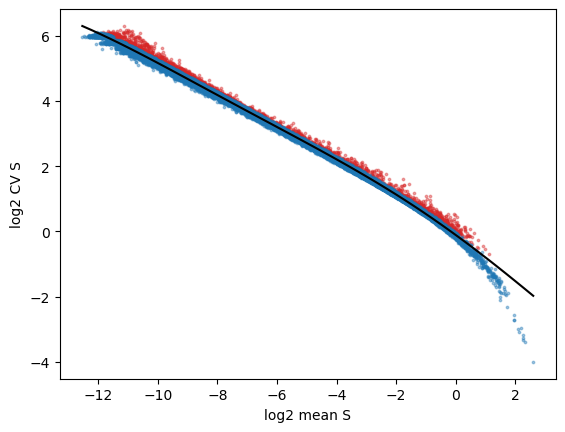

In [40]:
cv_vs_mean_keep = filter_cv_vs_mean(rna.X.toarray().T, N=1999, max_expr_avg=50)

#### Scaling

In [18]:
sc.pp.scale(rna, max_value=10)

#### PCA and neighbourhood graph

In [19]:
sc.tl.pca(rna, svd_solver='arpack')

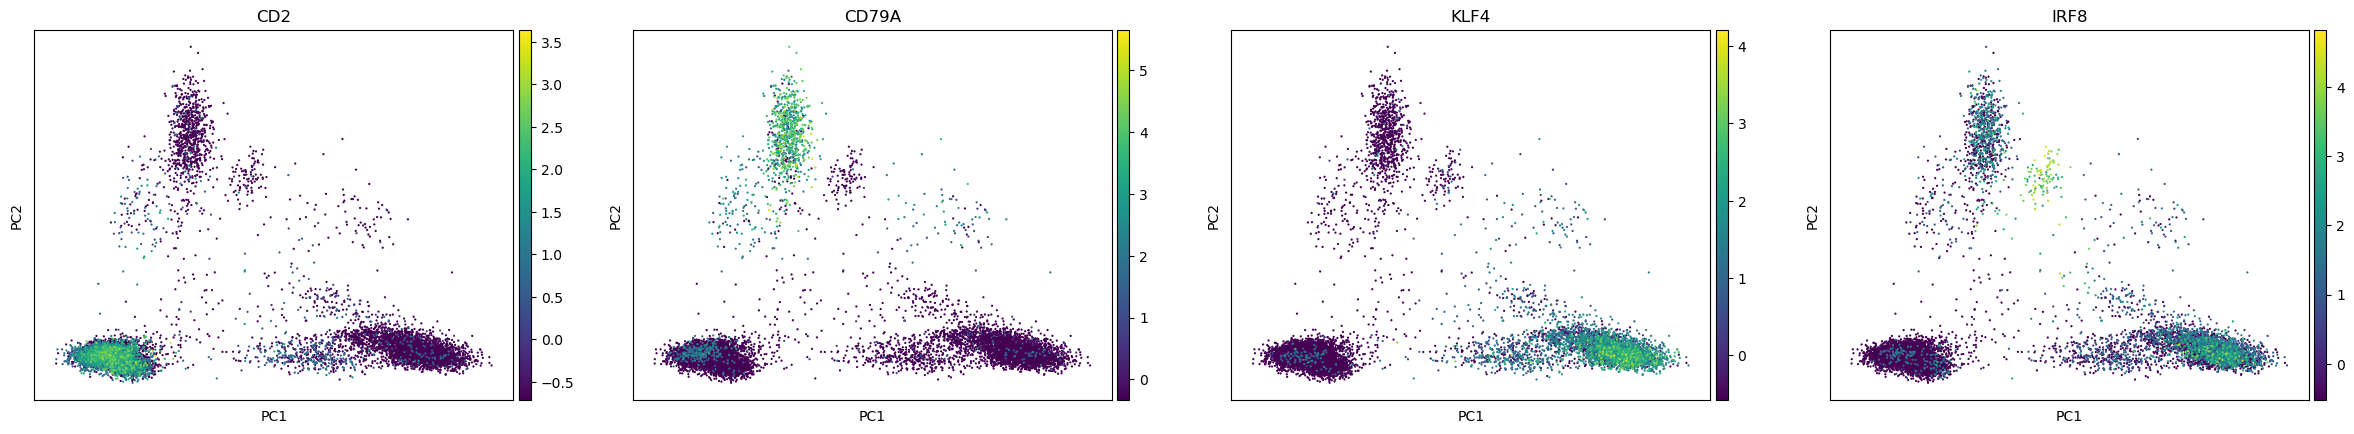

In [20]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

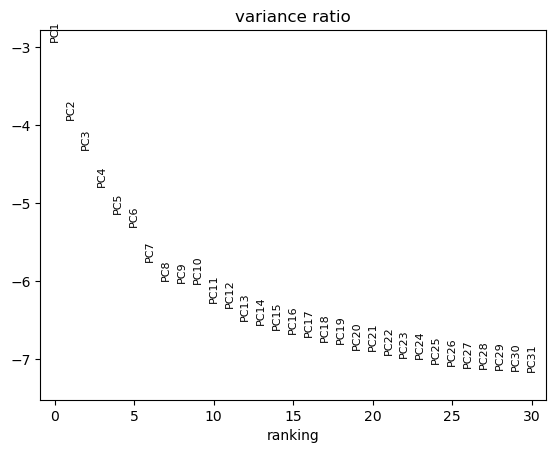

In [21]:
sc.pl.pca_variance_ratio(rna, log=True)

In [22]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

#### Non-linear dimensionality reduction and clustering

In [46]:
sc.tl.leiden(rna, resolution=.5)

In [47]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


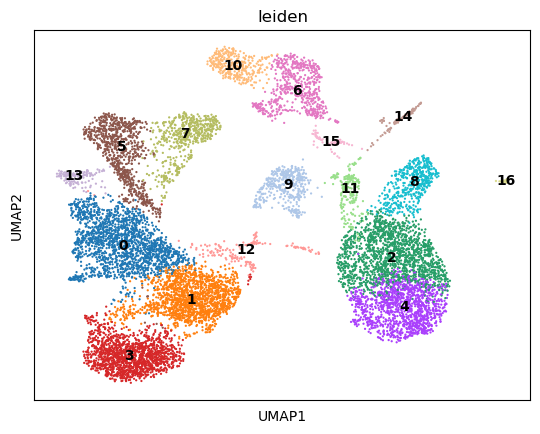

In [48]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

#### Marker genes and celltypes

In [49]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWa

In [50]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

0_n            0_p     1_n            1_p      2_n  2_p     3_n  \
0    INPP4B   0.000000e+00    LEF1   0.000000e+00   SLC8A1  0.0   BACH2   
1      IL32   0.000000e+00  BCL11B   0.000000e+00    NEAT1  0.0    LEF1   
2       LTB   0.000000e+00   BACH2   0.000000e+00   PLXDC2  0.0   PDE3B   
3     SYNE2   0.000000e+00   CAMK4   0.000000e+00     AOAH  0.0  THEMIS   
4      ANK3   0.000000e+00    FHIT   0.000000e+00     DPYD  0.0   NELL2   
5    CDC14A   0.000000e+00  MALAT1   0.000000e+00     JAK2  0.0  BCL11B   
6      IL7R   0.000000e+00  RPS27A   0.000000e+00     TYMP  0.0   CAMK4   
7     ITGB1  7.046075e-311    TCF7  4.568634e-300     ZEB2  0.0    CD8B   
8  ARHGAP15   0.000000e+00   RPS27  1.127466e-311     FCN1  0.0  OXNAD1   
9    BCL11B   0.000000e+00  INPP4B  2.331635e-284  DENND1A  0.0     TXK   

             3_p       4_n  4_p    5_n            5_p      6_n            6_p  \
0   0.000000e+00      VCAN  0.0   CCL5   0.000000e+00    BANK1   0.000000e+00   
1   0.000000e+00    PLXDC2  0.0   NKG7  6.546742e-264     CD74   0.000000e+00   
2   0.000000e+00      DPYD  0.0   IL32  5.707433e-285  RALGPS2  2.564341e-316   
3   0.000000e+00     LRMDA  0.0  SYNE2  2.601559e-216     AFF3  1.996320e-313   
4   0.000000e+00  ARHGAP26  0.0  PRKCH  6.220683e-203    MS4A1  1.361489e-278   
5   0.000000e+00      FCN1  0.0   GZMA  1.998591e-175  OSBPL10  8.911801e-228   
6   0.000000e+00     NEAT1  0.0  SKAP1  4.924020e-185  HLA-DRA  6.100698e-255   
7  1.348443e-317      ZEB2  0.0    A2M  9.922432e-164    CD79A  1.017944e-225   
8   0.000000e+00     CSF3R  0.0  HLA-B  8.705361e-170     PAX5  4.409112e-221   
9  2.069845e-308       FOS  0.0  SYNE1  7.294193e-161      BLK  1.280614e-195   

     7_n            7_p     8_n            8_p     9_n            9_p  \
0   GNLY   0.000000e+00  TCF7L2   0.000000e+00   NEAT1  4.718740e-212   
1   NKG7  1.322671e-278    PSAP   0.000000e+00  PLXDC2  2.628649e-182   
2  CD247  1.510323e-282     LYN   0.000000e+00    ZEB2  7.727209e-167   
3   PRF1  5.082505e-224    SAT1   0.000000e+00    LYST  6.523804e-153   
4  KLRD1  2.917566e-175   MTSS1  3.601394e-298    DPYD  1.411011e-156   
5   GZMA  3.913493e-171    CST3  5.585041e-296  SLC8A1  1.506375e-141   
6  SYNE1  4.917200e-165    WARS  7.996387e-289    TYMP  1.073279e-145   
7  PRKCH  8.991923e-170    CTSS  2.783907e-316     LYN  1.311260e-143   
8   CTSW  7.274806e-158   COTL1  1.043805e-282    FCN1  3.184457e-135   
9  MCTP2  1.457130e-153    TYMP  4.803133e-299    AOAH  1.301601e-141   

      10_n           10_p      11_n           11_p    12_n          12_p  \
0     IGHM  1.717861e-288      CD74  9.324114e-156   RPS29  5.846130e-17   
1     AFF3  7.544331e-270      CST3  8.708398e-113   RPS12  4.711173e-16   
2    BANK1  4.769292e-241   HLA-DRA  1.487532e-113   RPS27  5.716093e-15   
3     CD74  1.556831e-232       LYZ  2.605194e-116   RPS14  1.143721e-13   
4    FCRL1  6.639310e-170  HLA-DRB1  9.719021e-105   RPL13  2.994001e-13   
5  RALGPS2  3.628711e-166     HDAC9  5.792380e-103   RPL30  8.805334e-12   
6  HLA-DRA  5.218847e-177    SAMHD1  1.959876e-107   RPL32  3.015811e-10   
7    BACH2  8.734867e-164  HLA-DPA1   9.944090e-94   RPS21  3.503712e-10   
8     PAX5  3.466903e-149  HLA-DPB1   8.756005e-90   RPS26  1.133104e-09   
9    MS4A1  3.121559e-133      ACTB   1.061893e-91  RPL27A  5.494634e-09   

      13_n          13_p      14_n           14_p     15_n          15_p  \
0  SLC4A10  6.330097e-59      TCF4  2.131751e-108    BANK1  3.763627e-47   
1     NKG7  5.384804e-49      RHEX   9.108115e-85     AFF3  3.540162e-43   
2  PHACTR2  5.413391e-47      IRF8   2.498894e-83     CD74  4.056830e-40   
3     RORA  8.477116e-45    FCHSD2   1.102104e-83   MARCH1  3.041275e-38   
4    SYNE2  8.133896e-43      UGCG   2.849745e-78      LYN  1.349816e-37   
5     IL7R  1.387636e-38      AFF3   3.814444e-81  HLA-DRA  1.141581e-35   
6    SKAP1  5.995919e-38      CD74   5.871126e-85   PLXDC2  9.282730e-33   
7      A2M  7.309573e-37      PLD4   6.52

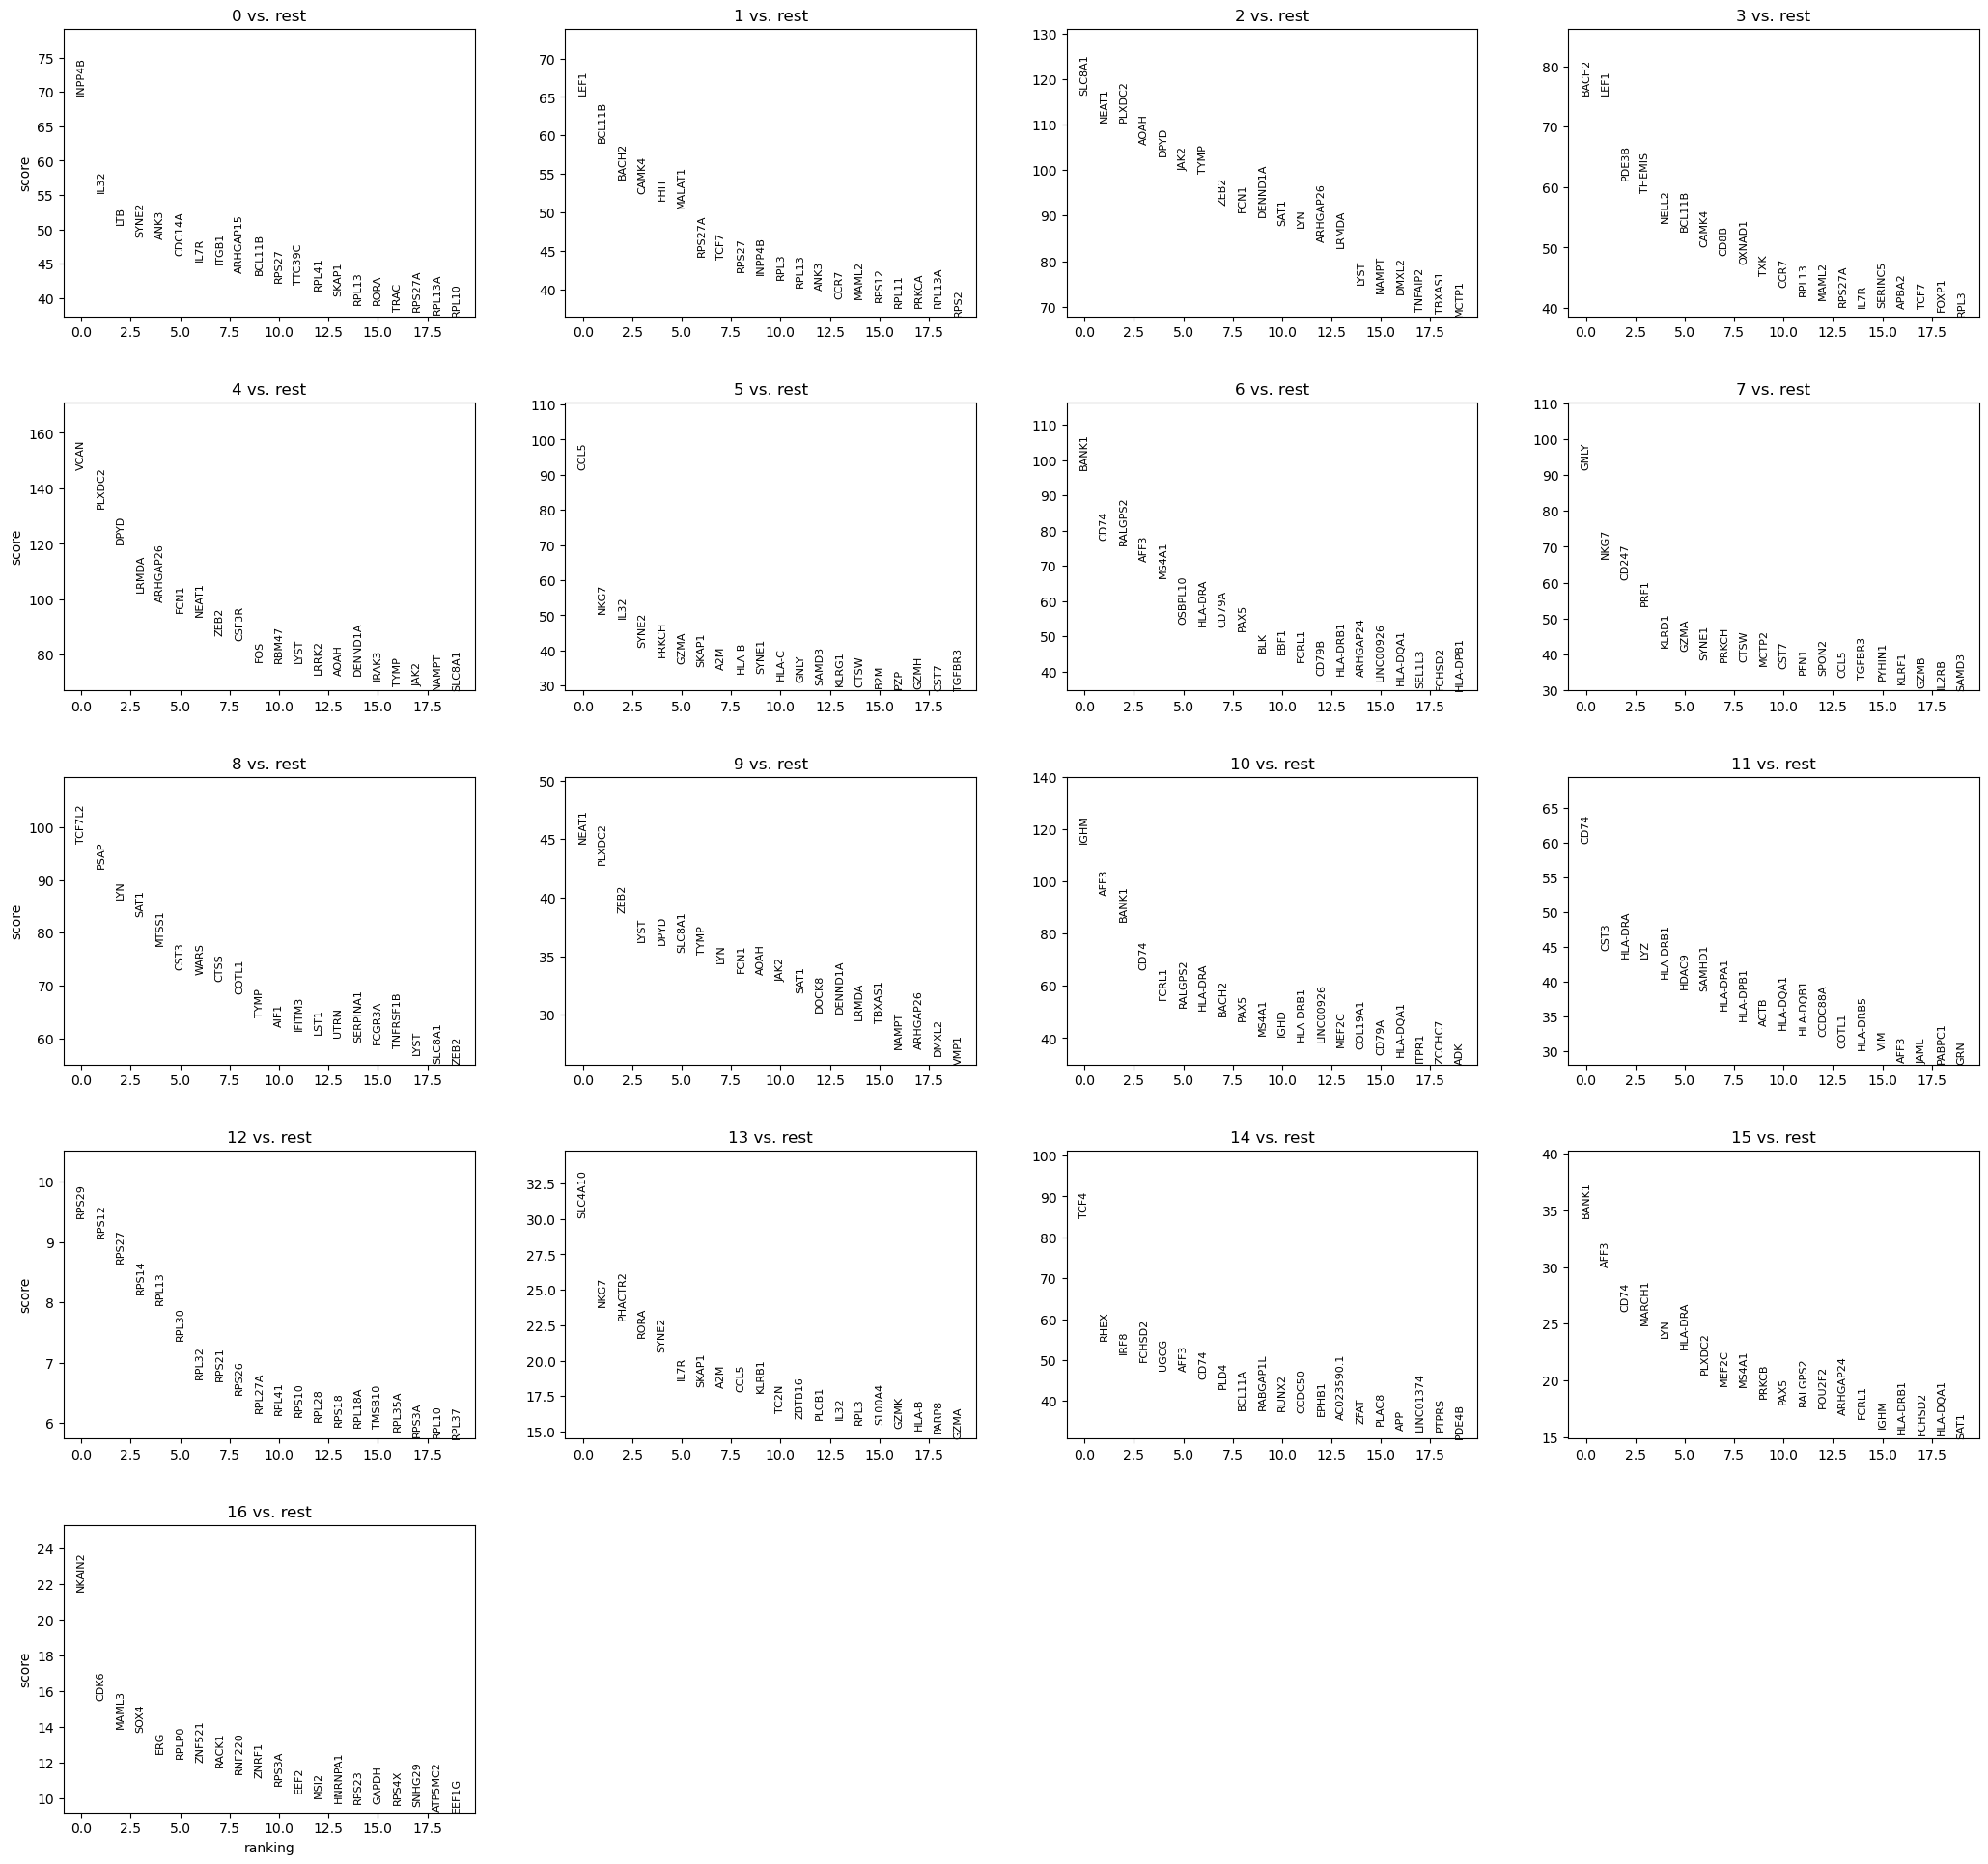

In [51]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

In [62]:
mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "12", "15", "16" ]))
# Analogous to
#   rna = rna[~rna.obs.leiden.isin(["9", "12", "15"])]
# but doesn't copy the object

In [63]:
new_cluster_names = {
    "0": "CD4+ memory T", "3": "CD8+ naïve T", "1": "CD4+ naïve T",
    "5": "CD8+ activated T", "7": "NK", "13": "MAIT",
    "6": "memory B", "10": "naïve B",
    "4": "CD14 mono", "2": "intermediate mono", "8": "CD16 mono",
    "11": "mDC", "14": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)

In [64]:
np.unique(rna.obs.celltype)

array(['CD14 mono', 'CD16 mono', 'CD4+ memory T', 'CD4+ naïve T',
       'CD8+ activated T', 'CD8+ naïve T', 'MAIT', 'NK',
       'intermediate mono', 'mDC', 'memory B', 'naïve B', 'pDC'],
      dtype=object)

In [65]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

/tmp/ipykernel_446955/2053379708.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  rna.obs.celltype.cat.reorder_categories([


In [66]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


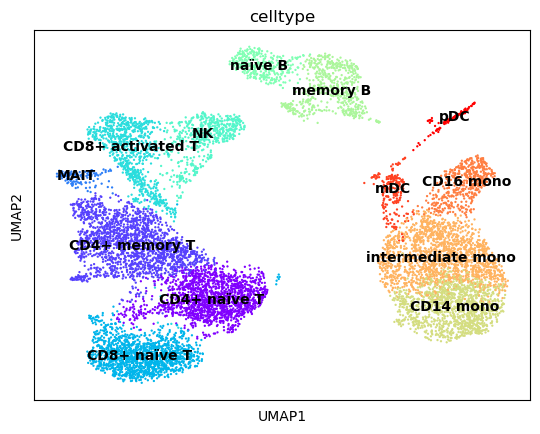

In [67]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

In [68]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'SLC4A10',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'CLEC10A', 'IRF8', 'TCF4']

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


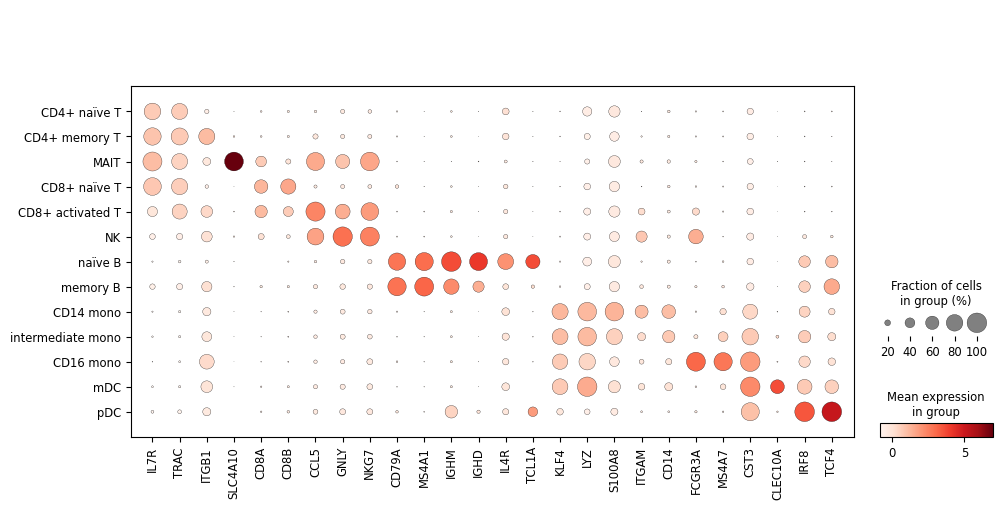

In [69]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

#### Feature selection

In [70]:
rna

AnnData object with n_obs × n_vars = 10887 × 26349
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [71]:
rna.raw = rna

In [72]:
rna = rna[:, cv_vs_mean_keep]

In [73]:
mdata.mod['rna'] = rna
mdata.mod['rna']

View of AnnData object with n_obs × n_vars = 10887 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [74]:
mdata.write("pbmc10k.h5mu")

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/mudata/_core/mudata.py:578: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_mod.loc[:, colname] = col


## ATAC

In [40]:
mdata = mu.read("pbmc10k.h5mu")

In [23]:
atac = mdata.mod['atac']
atac  # an AnnData object

AnnData object with n_obs × n_vars = 11909 × 108377
    var: 'gene_ids', 'feature_types', 'genome', 'interval'
    uns: 'atac', 'files'

#### Preprocessing

#### QC

In [25]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

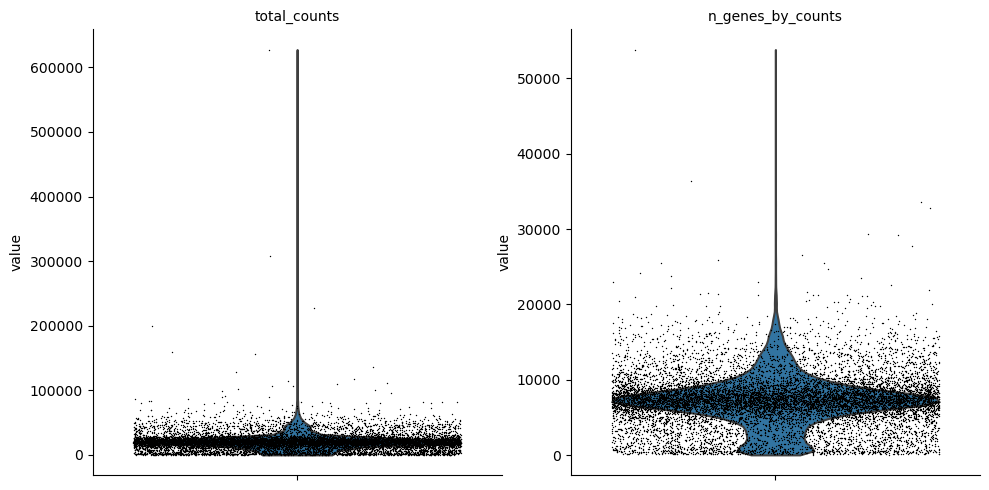

In [26]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [27]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 10)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=10)
# but does in-place filtering and avoids copying the object

In [29]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 2000) & (x <= 15000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 4000) & (x <= 40000))

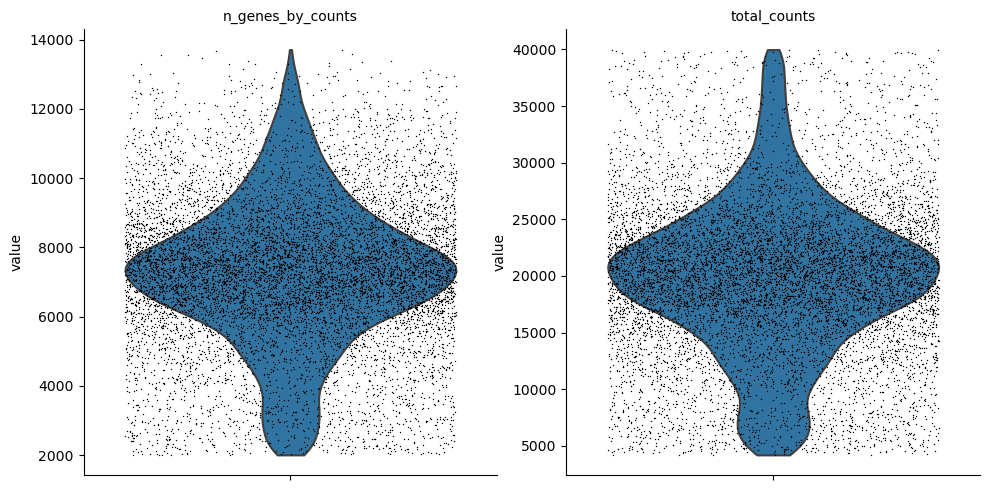

In [30]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

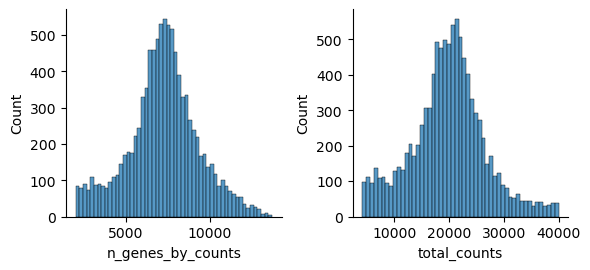

In [31]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

#### Nucleosome signal

In [32]:
atac.obs['NS']=1

In [33]:
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'atac', 'files'

In [34]:
ac.tl.locate_fragments(atac, fragments="atac_fragments.tsv.gz")

[W::hts_idx_load3] The index file is older than the data file: atac_fragments.tsv.gz.tbi


[W::hts_idx_load3] The index file is older than the data file: atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]


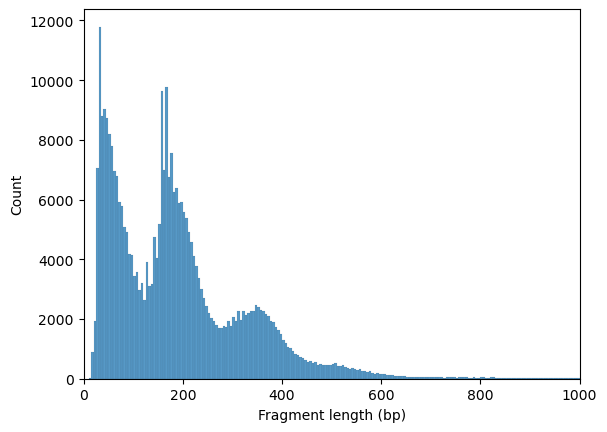

In [35]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [36]:
ac.tl.nucleosome_signal(atac, n=1e6)

[W::hts_idx_load3] The index file is older than the data file: atac_fragments.tsv.gz.tbi
Reading Fragments: 100%|█████████████████████████████████████████████████████████████| 1000000/1000000 [00:03<00:00, 310274.45it/s]


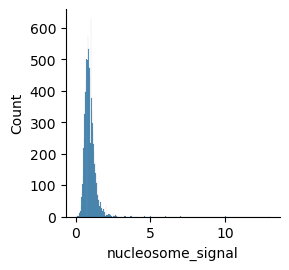

In [37]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

#### TSS enrichment

In [38]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

Chromosome   Start     End          gene_id   gene_name
AL627309.1       chr1  120931  133723  ENSG00000238009  AL627309.1
AL627309.5       chr1  149706  173862  ENSG00000241860  AL627309.5
AL627309.4       chr1  160445  160446  ENSG00000241599  AL627309.4

In [39]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000)  # by default, features=ac.tl.get_gen

[W::hts_idx_load3] The index file is older than the data file: atac_fragments.tsv.gz.tbi
Fetching Regions...: 100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:40<00:00, 25.00it/s]


#### Normalisation

In [40]:
# Save original counts
atac.layers["counts"] = atac.X

In [41]:
ac.pp.tfidf(atac, scale_factor=1e4)

In [42]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

#### Feature selection

In [43]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1., min_disp=.5)

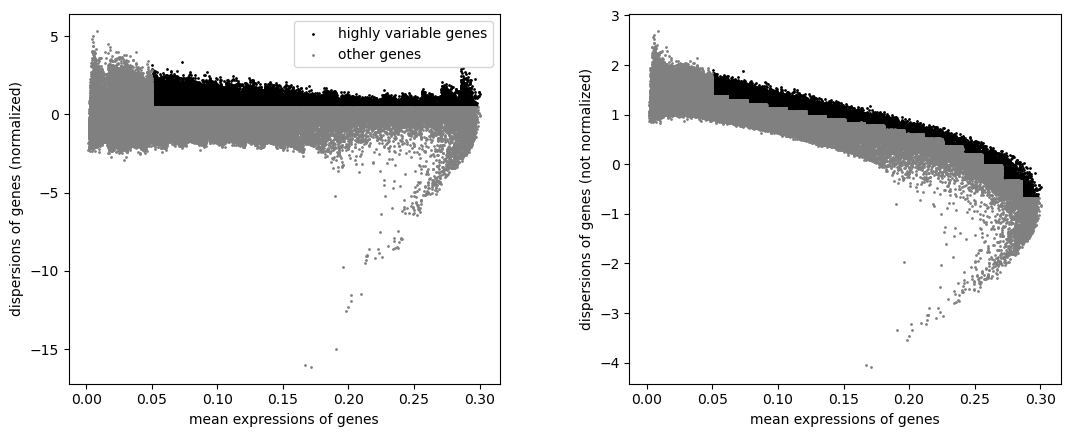

In [44]:
sc.pl.highly_variable_genes(atac)

In [45]:
np.sum(atac.var.highly_variable)

19430

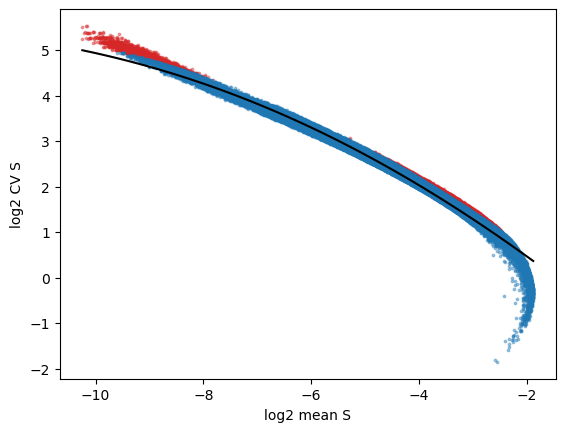

In [235]:
cv_vs_mean_keep = filter_cv_vs_mean(atac.X.toarray().T, N=4999, max_expr_avg=50)

#### Scaling

In [46]:
atac.raw = atac

In [47]:
atac

AnnData object with n_obs × n_vars = 10069 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'atac', 'files', 'log1p', 'hvg'
    layers: 'counts'

#### Analysis

#### LSI

In [48]:
ac.tl.lsi(atac)

In [49]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [50]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

#### PCA

In [51]:
sc.pp.scale(atac)
sc.tl.pca(atac)

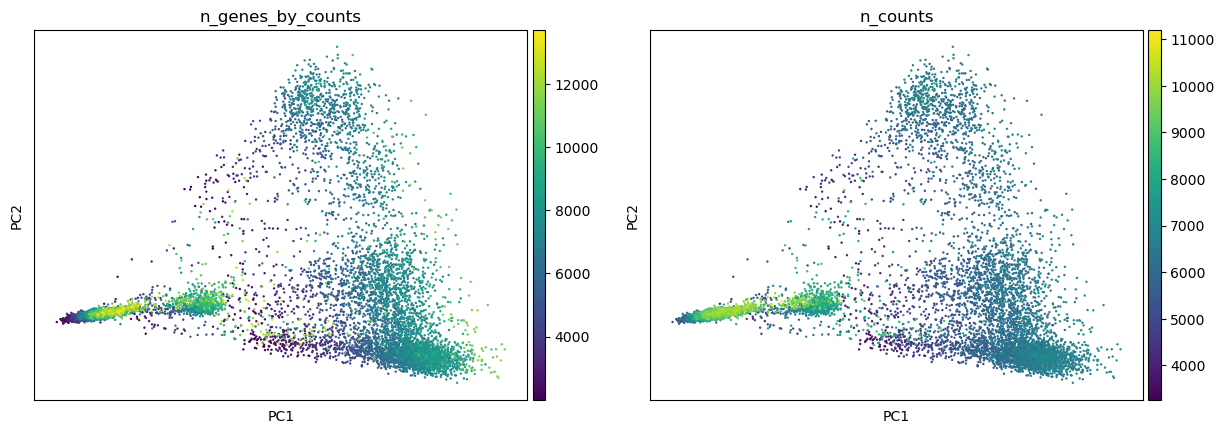

In [52]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [53]:
#atac.uns['atac']['peak_annotation'].tail()
#
#Alternatively add peak annotation from a TSV file
ac.tl.add_peak_annotation(atac, annotation="atac_peak_annotation.tsv")

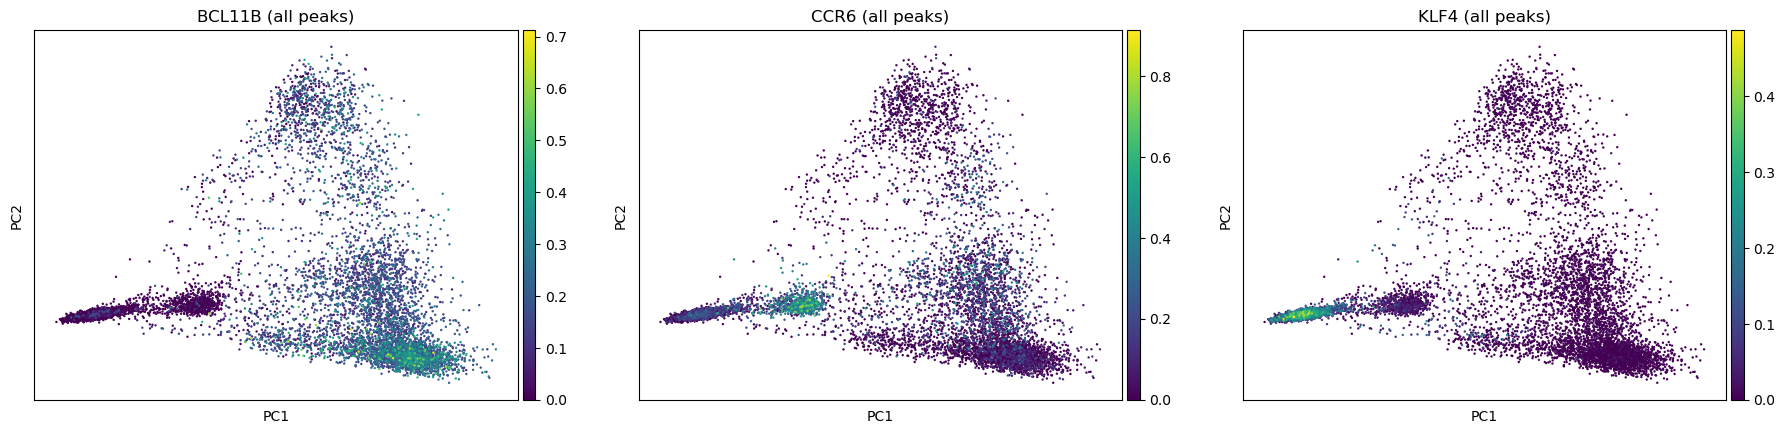

In [54]:
ac.pl.pca(atac, color=["BCL11B", "CCR6", "KLF4"], average="total")

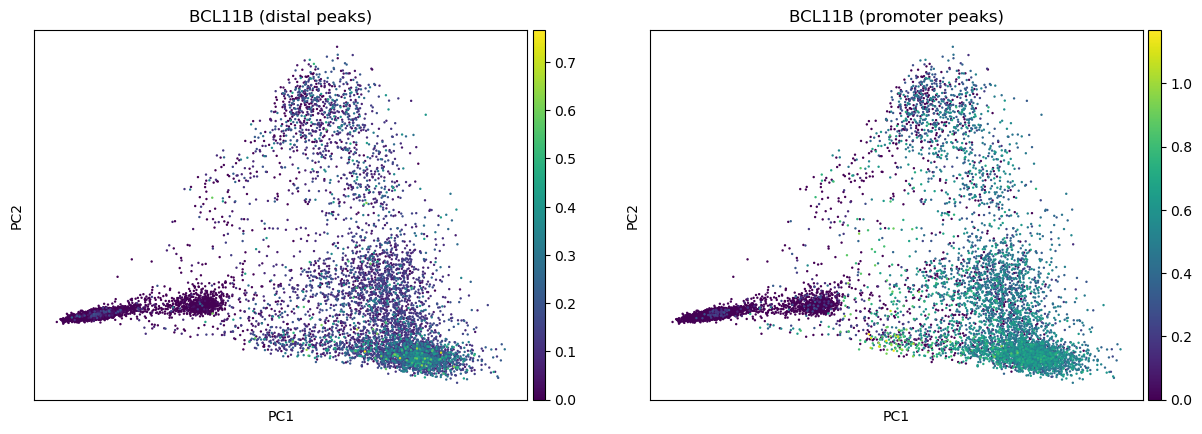

In [55]:
ac.pl.pca(atac, color="BCL11B", average="peak_type")

In [56]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

#### Non-linear dimensionality reduction and clustering

In [247]:
sc.tl.leiden(atac, resolution=.5)

In [248]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


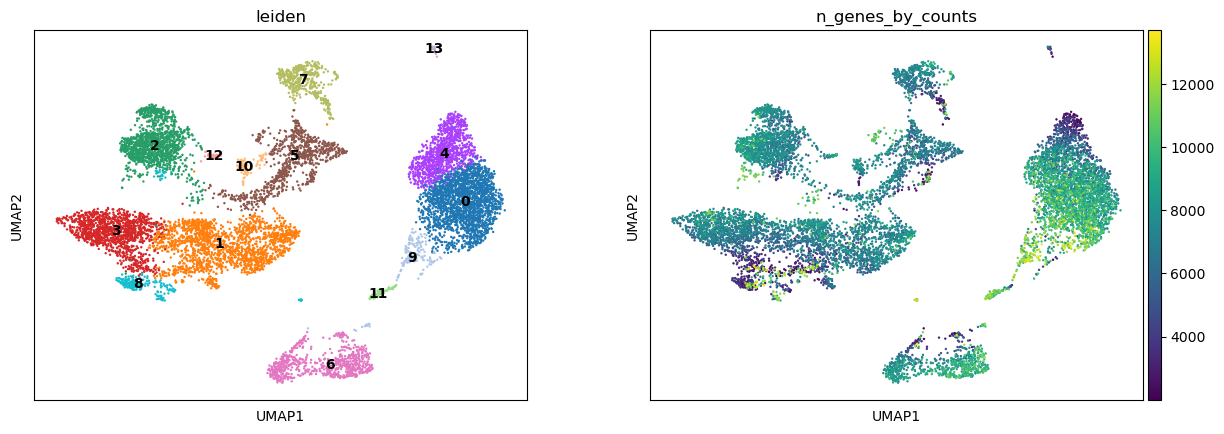

In [249]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

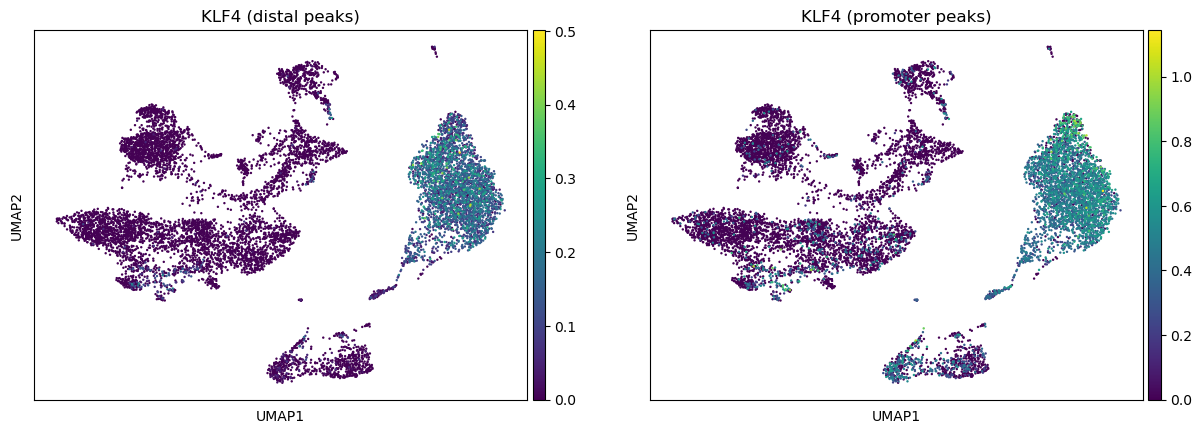

In [256]:
ac.pl.umap(atac, color=["KLF4"], average="peak_type")

#### Marker genes and celltypes

In [257]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [258]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.options.display.max_rows = 50
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

0_n                    0_g  0_p  \
0  chr9:107480158-107492721                   KLF4  0.0   
1   chr20:50269694-50277398                 SMIM25  0.0   
2   chr22:38950570-38958424               APOBEC3A  0.0   
3  chr9:134369462-134387253                   RXRA  0.0   
4    chr3:72092464-72103763              LINC00877  0.0   
5    chr6:41268623-41279829                  TREM1  0.0   
6    chr2:47067863-47077814      TTC7A, AC073283.1  0.0   
7    chr6:41280331-41287503                  TREM1  0.0   
8  chr1:182143071-182150314  LINC01344, AL390856.1  0.0   
9      chr5:1476663-1483241         SLC6A3, LPCAT1  0.0   

                        1_n  \
0   chr14:22536559-22563070   
1     chr10:8041366-8062418   
2   chr14:99255246-99275454   
3  chr7:142782798-142813716   
4   chr20:59157931-59168100   
5   chr14:91240967-91256390   
6   chr14:99223600-99254668   
7    chr5:35850992-35860227   
8   chr10:33135632-33141841   
9   chr12:12464985-12469154   

                                                 1_g            1_p  \
0  TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...  6.099802e-279   
1                       GATA3, GATA3-AS1, AL390294.1  1.368001e-187   
2                                 BCL11B, AL109767.1  6.246482e-186   
3  TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...  5.883462e-180   
4                                             ZNF831  1.565146e-149   
5                                  GPR68, AL135818.1  2.667438e-148   
6                                 BCL11B, AL109767.1  1.957424e-149   
7                                               IL7R  2.991548e-141   
8                                              IATPR  5.904255e-135   
9                                 BORCS5, AC007619.1  7.514729e-130   

                         2_n                 2_g            2_p  \
0     chr2:86783559-86792275                CD8A   0.000000e+00   
1    chr11:66311352-66319301   CD248, AP001107.3  1.794013e-289   
2    chr14:99255246-99275454  BCL11B, AL109767.1  1.489487e-291   
3    chr12:10552886-10555668           LINC02446  6.703846e-230   
4   chr2:136122469-136138482               CXCR4  2.560258e-256   
5    chr14:99181080-99219442  BCL11B, AL162151.1  6.191010e-240   
6    chr14:99223600-99254668  BCL11B, AL109767.1  2.437561e-222   
7     chr1:24500773-24509089      RCAN3, RCAN3AS  6.792231e-215   
8    chr17:82125073-82129615              CCDC57  7.765274e-208   
9  chr11:118906756-118931379               BCL9L  1.424064e-214   

                        3_n  \
0   chr14:99255246-99275454   
1   chr14:99223600-99254668   
2   chr14:99181080-99219442   
3   chr14:22536559-22563070   
4  chr7:142782798-142813716   
5   chr17:82125073-82129615   
6   chr17:40601555-40611036   
7   chr19:16363226-16378669   
8    chr8:30067057-30102417   
9     chr19:1061757-1096608   

                                                 3_g            3_p  \
0                                 BCL11B, AL109767.1  2.071922e-236   
1                                 BCL11B, AL109767.1  1.987288e-183   
2                                 BCL11B, AL162151.1  8.810603e-163   
3  TRAJ7, TRAJ6, TRAJ5, TRAJ4, TRAJ3, TRAJ2, TRAJ...  1.538257e-157   
4  TRBC1, TRBJ2-1, TRBJ2-2, TRBJ2-2P, TRBJ2-3, TR...  9.439555e-154   
5                                             CCDC57  8.358244e-142   
6                                            SMARCE1  9.012099e-139   
7                                EPS15L1, AC020917.3  6.444715e-140   
8                        LEPROTL1, SARAF, AC044849.1  6.807691e-140   
9                            ABCA7, POLR2E, ARHGAP45  3.879729e-136   

                        4_n                    4_g            4_p  \
0  chr9:107480158-107492721                   KLF4  1.194157e-158   
1   chr20:50269694-50277398                 SMIM25  7.379517e-135   
2  chr1:182143071-182150314  LINC01344, AL390856.1  3.952387e-119   
3  chr1:220876295-220883526           HLX, HLX-AS1  7.307749e-119   
4      chr5:1476663-1483241         SLC6A3,

In [270]:
mu.pp.filter_obs(atac, "leiden", lambda x: ~x.isin([ "8", "12", "13"]))
# Analogous to
#   atac = atac[~atac.obs.leiden.isin(["10", "14", "15", "16"])]
# but doesn't copy the object

In [271]:
new_cluster_names = {
    "0": "intermediate mono", "1": "CD4+ memory T", "2": "CD8+ naïve T", "3": "CD4+ naïve T", "4": "CD14 mono", "5": "CD8+ activated T", "6": "memory B",
    "7": "NK", "9": "mDC", "10": "MAIT", "11":"pDC", 
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

In [272]:
np.unique(atac.obs.celltype)

array(['CD14 mono', 'CD4+ memory T', 'CD4+ naïve T', 'CD8+ activated T',
       'CD8+ naïve T', 'MAIT', 'NK', 'intermediate mono', 'mDC',
       'memory B', 'pDC'], dtype=object)

In [273]:
np.unique([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
     'memory B',
    'CD14 mono', 'intermediate mono',
    'mDC', 'pDC'])

array(['CD14 mono', 'CD4+ memory T', 'CD4+ naïve T', 'CD8+ activated T',
       'CD8+ naïve T', 'MAIT', 'NK', 'intermediate mono', 'mDC',
       'memory B', 'pDC'], dtype='<U17')

In [274]:
atac.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
     'memory B',
    'CD14 mono', 'intermediate mono',
    'mDC', 'pDC'], inplace=True)

/tmp/ipykernel_446955/457608321.py:1: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  atac.obs.celltype.cat.reorder_categories([


In [275]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


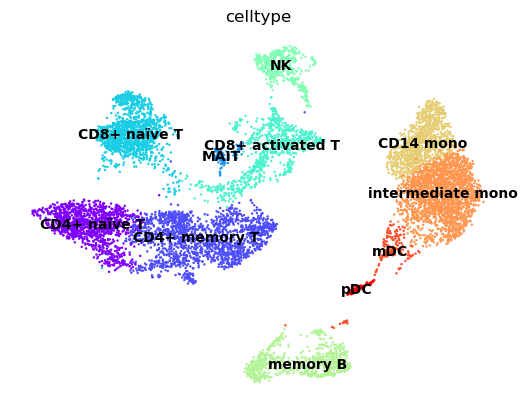

In [276]:
sc.pl.umap(atac, color="celltype", legend_loc="on data", frameon=False)


In [277]:
marker_genes = ['IL7R', 'TRAC',
                'GATA3',
                'SLC4A10',
                'CD8A', 'CD8B', 'CD248', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHD', 'IGHM', 'TNFRSF13C',
                'IL4R', 'KLF4', 'LYZ', 'S100A8', 'ITGAM', 'CD14',
                'FCGR3A', 'MS4A7', 'CST3',
                'CLEC10A', 'IRF8', 'TCF4']

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


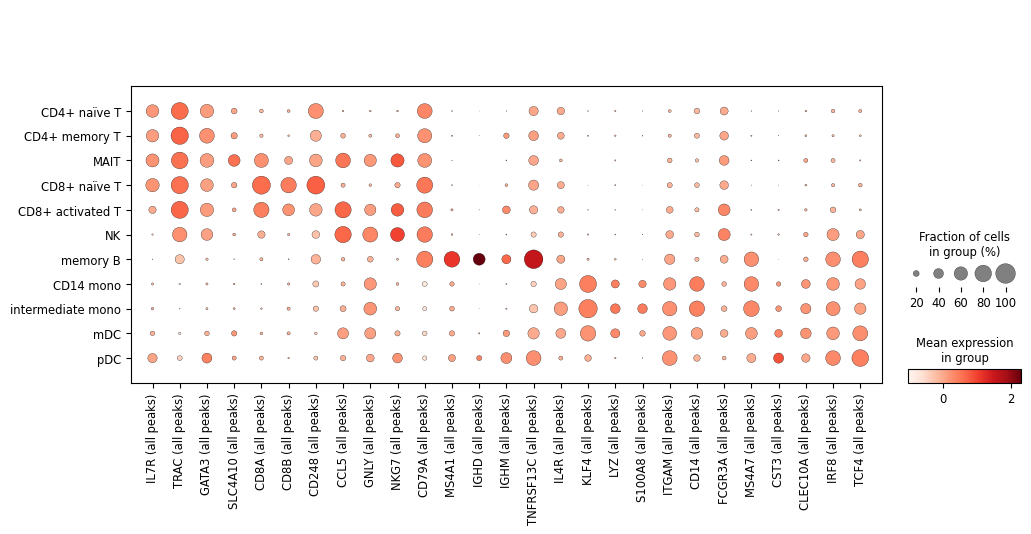

In [278]:
ac.pl.dotplot(atac, marker_genes, groupby='celltype')

#### Feature selection

In [279]:
atac

AnnData object with n_obs × n_vars = 9778 × 106086
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'files', 'log1p', 'hvg', 'lsi', 'neighbors', 'pca', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'celltype_colors'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [280]:
atac.raw = atac

In [281]:
atac = atac[:, cv_vs_mean_keep]

In [282]:
mdata.mod['atac'] = atac
mdata.mod['atac']

View of AnnData object with n_obs × n_vars = 9778 × 5000
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score', 'n_counts', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'interval', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'atac', 'files', 'log1p', 'hvg', 'lsi', 'neighbors', 'pca', 'leiden', 'umap', 'leiden_colors', 'rank_genes_groups', 'celltype_colors'
    obsm: 'X_lsi', 'X_pca', 'X_umap'
    varm: 'LSI', 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [283]:
mu.write("pbmc10k.h5mu/atac", atac)

#### Compare cell type annotation

In [49]:
mu.pp.intersect_obs(mdata)

In [50]:
from sklearn.metrics import adjusted_rand_score as ari
ari(mdata.obs['rna:celltype'], mdata.obs['atac:celltype'])

0.6758889302832121

In [51]:
# Calculate total number of cells of respective ATAC celltypes
df_total = (
    mdata.obs.groupby("atac:celltype").
        size().
        reset_index(name="n_total").
        set_index("atac:celltype")
)

# Calculate number of cells for each pair of RNA-ATAC celltype annotation
df = (
    mdata.obs.groupby(["atac:celltype", "rna:celltype"]).
        size().
        reset_index(name="n").
        set_index("atac:celltype").
        join(df_total).
        reset_index()
)

# Calculate a fraction of cells of each RNA celltype (n)
# for each ATAC celltype (/ n_total)
df_frac = df.assign(frac = lambda x: x.n / x.n_total)

In [52]:
df_wide = df_frac.set_index("atac:celltype").pivot(columns="rna:celltype", values="frac")

<AxesSubplot: xlabel='rna:celltype', ylabel='atac:celltype'>

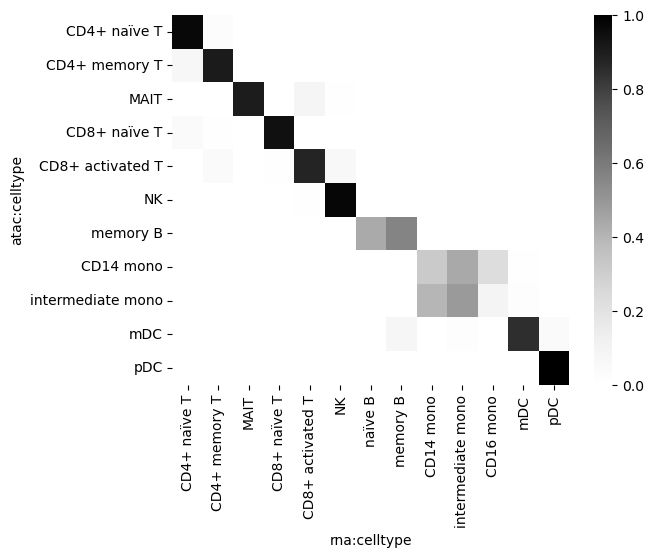

In [53]:
import seaborn as sns
sns.heatmap(df_wide, cmap="Greys")